# Portland Trail Blazers - Customer Lifetime Value (Clustering)
* StelllarAlgo Data Science
* Ryan Kazmerik
* Jul 15, 2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#from pandas_profiling import ProfileReport

**Customer Lifetime Value (CLTV)** represents the total amount of money a customer is expected to spend in a business during his/her lifetime. This is an important metric to monitor because it helps to make decisions about how much money to invest in acquiring new customers and retaining existing ones.

## Data Preprocessing



In [2]:
df = pd.read_parquet("./data/ptb_ticket_purchases_all.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3949410 entries, 0 to 3949409
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   dimcustomermasterid  int64  
 1   purchasedate         object 
 2   ticketcount          int64  
 3   revenue              float64
 4   isplanproduct        bool   
 5   producttype          object 
 6   subproductname       object 
 7   seasonyear           int64  
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 214.7+ MB


In [3]:
df.head()

,dimcustomermasterid,purchasedate,ticketcount,revenue,isplanproduct,producttype,subproductname,seasonyear
0,3,2017-11-21,3,75.0,False,Other,Group,2017
1,16,2018-02-02,2,85.0,True,Package,Half Season,2017
2,16,2018-02-02,2,85.0,True,Package,Half Season,2017
3,48,2019-02-05,1,10.0,False,Individual,Individual,2018
4,87,2021-05-28,2,144.0,False,Individual,Individual,2020


For our analysis we will only consider **non-package buyers**, let's see how much data we have for NP buyers and what sub-products are included:

In [4]:
df['isplanproduct'].value_counts()

False    2931853
True     1017557
Name: isplanproduct, dtype: int64

Remove the rows where isplanproduct = True:

In [5]:
df = df[df['isplanproduct'] == False]

df.drop(columns=["isplanproduct"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2931853 entries, 0 to 3949409
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   dimcustomermasterid  int64  
 1   purchasedate         object 
 2   ticketcount          int64  
 3   revenue              float64
 4   producttype          object 
 5   subproductname       object 
 6   seasonyear           int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 178.9+ MB


Let's include data from 2018 to present in our analysis:

In [6]:
df = df[df["seasonyear"] >= 2018]
df.shape

(2471314, 7)

We'll also have a look at the included product and subproduct types:

In [7]:
df["producttype"].value_counts()

Individual    2246352
Comp           142473
Other           82489
Name: producttype, dtype: int64

In [8]:
df["subproductname"].value_counts()

Individual           2245724
Comp                  141707
Suite                  39145
Group                  38697
Deposit                 1842
Group Broker            1459
Suite Broker            1345
Comp Broker              766
Individual Broker        628
Deposit Broker             1
Name: subproductname, dtype: int64

Let's remove the broker records so we are looking at actual customers:

In [9]:
df = df[df["subproductname"].isin(["Individual", "Comp", "Suite", "Group", "Deposit"])]
df.reset_index(drop=True, inplace=True)

df["subproductname"].value_counts()

Individual    2245724
Comp           141707
Suite           39145
Group           38697
Deposit          1842
Name: subproductname, dtype: int64

In [10]:
df.head(10)

,dimcustomermasterid,purchasedate,ticketcount,revenue,producttype,subproductname,seasonyear
0,48,2019-02-05,1,10.0,Individual,Individual,2018
1,87,2021-05-28,2,144.0,Individual,Individual,2020
2,95,2021-05-24,4,160.0,Individual,Individual,2020
3,35,2020-02-08,5,90.0,Individual,Individual,2019
4,70,2019-03-27,1,116.5,Individual,Individual,2018
5,20,2019-02-27,8,112.0,Individual,Individual,2018
6,48,2019-02-05,1,10.0,Individual,Individual,2018
7,95,2021-05-06,2,134.0,Individual,Individual,2020
8,95,2021-05-24,5,200.0,Individual,Individual,2020
9,41,2021-09-15,2,242.0,Individual,Individual,2021


## Exploratory Data Analysis (EDA)

Let's have a look at the data and decide whether we need any data cleaning and data transformation for further analysis.

In [11]:
#profile = ProfileReport(df, minimal=True)
#profile.to_file("pandas-profile-report.html")

By reading the profiling report, we can see that the following actions should be taken to improve the dataset quality:
* Remove missing values from revenue (33.3%)
* Remove zero values from revenue (7.4%)

In [12]:
df.dropna(subset=['revenue'], inplace=True)
df['revenue'].isnull().sum()

0

Let's also drop any rows where revenue = 0, and then check the value counts to ensure the zero values are gone

In [13]:
df = df[df['revenue'] > 0]
df['revenue'].value_counts(bins=[0, 1000, 10000, 100000])

(-0.001, 1000.0]       1424893
(1000.0, 10000.0]        28898
(10000.0, 100000.0]        208
Name: revenue, dtype: int64

### Data Types

Let's look at the data types in our dataframe to see if we need to convert any values to a different type

In [14]:
df.dtypes

dimcustomermasterid      int64
purchasedate            object
ticketcount              int64
revenue                float64
producttype             object
subproductname          object
seasonyear               int64
dtype: object

Purchase date should be a datetime not an object (string), all of the other inferred data types look correct

In [15]:
df['purchasedate'] =  pd.to_datetime(df['purchasedate'], format='%Y-%m-%d')

### Distributions

Let's look at the distributions for our three key fields: purchasedate, ticketcount and revenue

Text(0, 0.5, 'Fans')

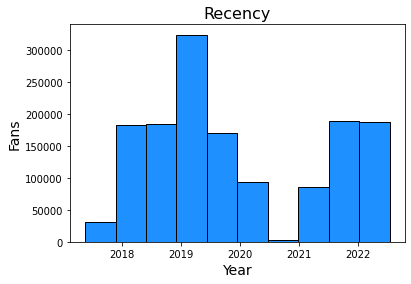

In [16]:
plt.hist(df["purchasedate"], color='dodgerblue', edgecolor='black')
plt.title("Recency", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Fans", fontsize=14)

There was abnormally low purchasing during the 2020 season because of stadium closures due to the COVID-19 pandemic. There are also some outlier purchases from before 2017

We may want to remove these from our training dataset, but let's leave them in for now

Text(0, 0.5, 'Fans')

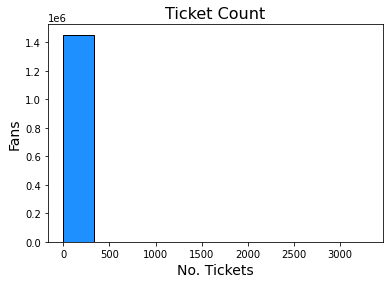

In [17]:
plt.hist(df["ticketcount"], color='dodgerblue', edgecolor='black')
plt.title("Ticket Count", fontsize=16)
plt.xlabel("No. Tickets", fontsize=14)
plt.ylabel("Fans", fontsize=14)

In [18]:
df["ticketcount"].value_counts(bins=[0, 5, 10, 50, 100, 10000])

(-0.001, 5.0]       1397196
(5.0, 10.0]           43389
(10.0, 50.0]          12528
(50.0, 100.0]           579
(100.0, 10000.0]        307
Name: ticketcount, dtype: int64

We can see that ticket count is highly skewed toward 1 ticket, we may want to remove the outliers here but let's leave it for now

Text(0, 0.5, 'Fans')

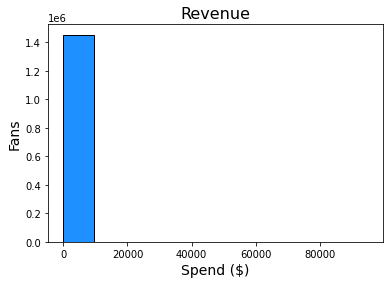

In [19]:
plt.hist(df["revenue"], color='dodgerblue', edgecolor='black')
plt.title("Revenue", fontsize=16)
plt.xlabel("Spend ($)", fontsize=14)
plt.ylabel("Fans", fontsize=14)

In [20]:
df["revenue"].value_counts(bins=[0, 100, 1000, 10000, 100000])

(100.0, 1000.0]        733893
(-0.001, 100.0]        691000
(1000.0, 10000.0]       28898
(10000.0, 100000.0]       208
Name: revenue, dtype: int64

Most fans spend between 1 and 1000 dollars on a purchase, but some spend much more, we may want to remove these outliers but let's leave them in for now

## Customer Segmentation

**RFM** stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:

* Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.

* Mid Value: In the middle of everything. Often purchasing (but not as much as our High Values), fairly frequent and generates moderate revenue.

* High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

### Recency

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

In [21]:
# create a generic user dataframe to keep dimcustomermasterid and new segmentation scores
df_customer = pd.DataFrame(df['dimcustomermasterid'].unique())
df_customer.columns = ['dimcustomermasterid']

# get the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('dimcustomermasterid')["purchasedate"].max().reset_index()
df_max_purchase.columns = ['dimcustomermasterid','maxpurchasedate']

# we take our observation point as the max invoice date in our dataset
df_max_purchase['recency'] = (df_max_purchase['maxpurchasedate'].max() - df_max_purchase['maxpurchasedate']).dt.days

#merge this dataframe to our new user dataframe
df_customer = pd.merge(df_customer, df_max_purchase[['dimcustomermasterid','recency']], on='dimcustomermasterid')

df_customer.head()

,dimcustomermasterid,recency
0,48,1255
1,87,412
2,95,416
3,35,887
4,70,916


In [22]:
df_customer["recency"].describe()

count    685468.000000
mean        809.971895
std         543.306111
min           0.000000
25%         236.000000
50%         953.000000
75%        1266.000000
max        1884.000000
Name: recency, dtype: float64

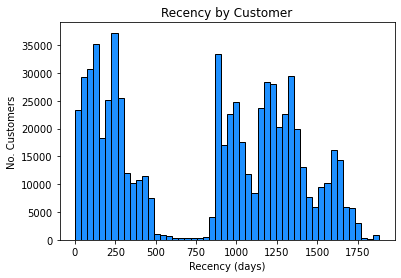

In [23]:
plt.hist(df_customer["recency"], bins=50, color="dodgerblue", edgecolor="black")
plt.title("Recency by Customer")
plt.ylabel("No. Customers")
plt.xlabel("Recency (days)")
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

We can observe a large gap in purchasing behaviour between ~850 - 500 days ago, which aligns with when COVID-19 was declared a global pandemic.

### Clustering Recency

We are going to apply K-means clustering to assign a recency score. We will use the elbow method to determine how many clusters we need:

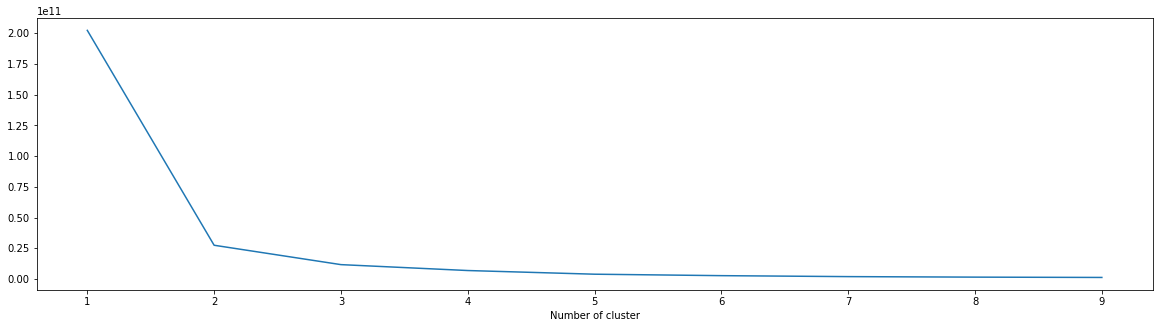

In [24]:
from sklearn.cluster import KMeans

cluster_dict={}
df_recency = df_customer[['recency']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    cluster_dict[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(cluster_dict.keys()), list(cluster_dict.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 3 is the optimal number of clusters

In [25]:
# build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['recency']])
df_customer['recencycluster'] = kmeans.predict(df_customer[['recency']])

#function for ordering clusters from worst to best
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

df_customer = order_cluster('recencycluster', 'recency', df_customer, False)

In [26]:
df_customer.groupby('recencycluster')["recency"].describe()

,count,mean,std,min,25%,50%,75%,max
recencycluster,,,,,,,,
0,175764.0,1454.542984,142.972970,1258.0,1334.0,1406.0,1592.0,1884.0
1,230561.0,1056.238063,128.076892,630.0,944.0,1039.0,1179.0,1257.0
2,279143.0,200.707945,124.631394,0.0,100.0,197.0,277.0,629.0


### Frequency

To create frequency clusters, we first need to find total number orders for each customer:

In [27]:
#get order counts for each user and create a dataframe with it
df_frequency = df.groupby('dimcustomermasterid')["purchasedate"].count().reset_index()
df_frequency.columns = ['dimcustomermasterid','frequency']

#add this data to our main dataframe
df_customer = pd.merge(df_customer, df_frequency, on="dimcustomermasterid")

In [31]:
df_customer["frequency"].describe()

count    685468.000000
mean          2.121177
std          11.006631
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        7162.000000
Name: frequency, dtype: float64

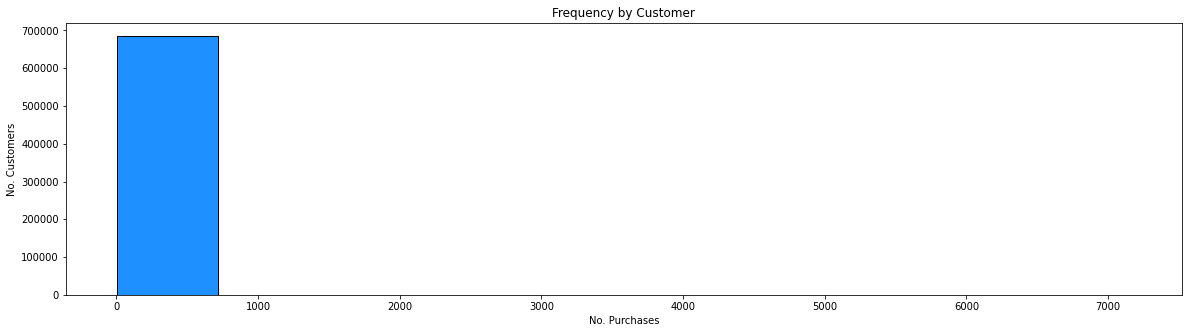

In [29]:
plt.hist(df_customer["frequency"], color="dodgerblue", edgecolor="black")
plt.title("Frequency by Customer")
plt.ylabel("No. Customers")
plt.xlabel("No. Purchases")
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

In [32]:
# build 3 clusters for frequency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['frequency']])
df_customer['frequencycluster'] = kmeans.predict(df_customer[['frequency']])

df_customer = order_cluster('frequencycluster', 'frequency', df_customer, False)

In [33]:
df_customer.groupby('frequencycluster')["frequency"].describe()

,count,mean,std,min,25%,50%,75%,max
frequencycluster,,,,,,,,
0,1.0,7162.000000,NaN,7162.0,7162.0,7162.0,7162.0,7162.0
1,892.0,148.672646,97.093198,76.0,101.0,142.0,154.0,1743.0
2,684575.0,1.919762,2.474744,1.0,1.0,1.0,2.0,75.0


### Revenue

Let’s add revenue to our dataset and cluster based on revenue:

In [35]:
df_revenue = df.groupby("dimcustomermasterid")["revenue"].sum().reset_index()

df_customer = pd.merge(df_customer, df_revenue, on="dimcustomermasterid")

In [39]:
df_customer["revenue"].describe()

count    6.854680e+05
mean     4.129896e+02
std      4.762904e+03
min      1.000000e+00
25%      9.600000e+01
50%      1.850000e+02
75%      3.665000e+02
max      2.174712e+06
Name: revenue, dtype: float64

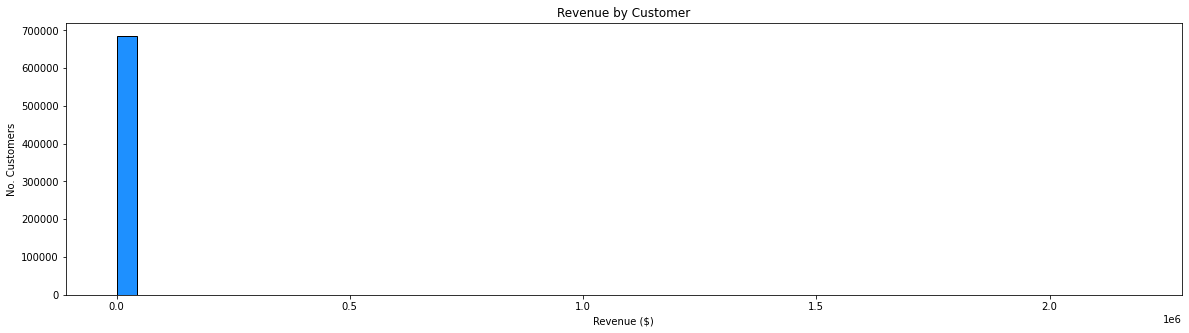

In [38]:
plt.hist(df_customer["revenue"], bins=50, color="dodgerblue", edgecolor="black")
plt.title("Revenue by Customer")
plt.ylabel("No. Customers")
plt.xlabel("Revenue ($)")
plt.rcParams["figure.figsize"] = (20,5)

plt.show()

In [40]:
# build 3 clusters for revenue and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['revenue']])
df_customer['revenuecluster'] = kmeans.predict(df_customer[['revenue']])

df_customer = order_cluster('revenuecluster', 'revenue', df_customer, False)

In [41]:
df_customer.groupby("revenuecluster")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
revenuecluster,,,,,,,,
0,1.0,2.174712e+06,NaN,2174711.94,2174711.94,2174711.94,2174711.94,2174711.94
1,63.0,3.466170e+05,167032.467820,175432.15,214752.32,301498.27,472967.36,936195.82
2,685404.0,3.779954e+02,1499.331137,1.00,96.00,185.00,366.00,162102.00


### Overall Score

We have scores (cluster numbers) for recency, frequency & revenue. Let’s create an overall score out of them:

In [43]:
#calculate overall score and use mean() to see details
df_customer['score'] = df_customer['recencycluster'] + df_customer['frequencycluster'] + df_customer['revenuecluster']
df_customer.groupby('score')['recency','frequency','revenue'].mean()

/var/folders/kp/vwm5bxcd72j3yf54l1xtsts80000gp/T/ipykernel_68084/874267582.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_customer.groupby('score')['recency','frequency','revenue'].mean()


,recency,frequency,revenue
score,,,
2,31.000000,7162.000000,2.174712e+06
3,1134.785714,118.428571,1.630800e+05
4,1453.855822,1.592660,3.885283e+02
5,1053.711926,2.302972,3.747723e+02
6,200.691013,2.272723,4.441838e+02


These scores are a bit hard to interpret, mostly because a few really large spenders are skewing the scoring process

### Visualization